In [44]:
import os
import sys
import math
import utils
import random
import layers
import dataset
import binvox_rw
import numpy as np
import pandas as pd
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
# tf.contrib.eager.enable_eager_execution() 
# place holders
x=tf.placeholder(tf.float32,[None,24,137,137,3]) 
y=tf.placeholder(tf.float32,[None,32,32,32])

# encoder network
cur_tensor=x
encoder_outputs=[cur_tensor]
print(cur_tensor.shape)
k_s = [3,3]
conv_filter_count = [96, 128, 256, 256, 256, 256]
for i in range(6): 
    ks=[7,7]if i is 0 else k_s  
    with tf.name_scope("encoding_block"): 
        cur_tensor=tf.map_fn(lambda a:tf.layers.conv2d(a,filters=conv_filter_count[i],padding='SAME',kernel_size= k_s,activation=None),cur_tensor)
        cur_tensor=tf.map_fn(lambda a:tf.layers.max_pooling2d(a,2,2),cur_tensor)
        cur_tensor=tf.map_fn(tf.nn.relu,cur_tensor)
        print(cur_tensor.shape)
        encoder_outputs.append(cur_tensor)

# flatten tensors
cur_tensor=tf.map_fn(tf.contrib.layers.flatten,cur_tensor)
cur_tensor=tf.map_fn(lambda a:tf.contrib.layers.fully_connected(a,1024,activation_fn=None),cur_tensor)
encoder_outputs.append(cur_tensor)
print(cur_tensor.shape)

# recurrent module
with tf.name_scope("recurrent_module"): 
    
    N,h_n=4,256
   
    recurrent_module=layers.GRU_R2N2(n_cells=N,n_hidden_state=h_n);

    # prepare input
    cur_tensor=encoder_outputs[-1]
    stacked_input=cur_tensor
    for i in range(3):
        stacked_input=tf.stack([stacked_input]*N,axis=0)
    print(stacked_input.shape)

    # initial hidden state
    hidden_state_list=[]
    hidden_state= tf.zeros_like(stacked_input[:,:,:,:,0,0:h_n])
    
    # feed batches of seqeuences
    for t in range(24):
        input_frames = stacked_input[:,:,:,:,t,:]
        hidden_state_list.append(hidden_state)
        hidden_state = recurrent_module.call(input_frames, hidden_state)
    print(hidden_state.shape)

# decoding network
cur_tensor=tf.transpose(hidden_state,[3,0,1,2,4])
print(cur_tensor.shape)

decoder_outputs=[cur_tensor]
cur_tensor=layers.unpool3D(cur_tensor)
print(cur_tensor.shape)
decoder_outputs.append(cur_tensor)

k_s = [3,3,3]
deconv_filter_count = [128, 128, 128, 64, 32, 2]
for i in range(2,4): 
    with tf.name_scope("decoding_block"):
        cur_tensor=tf.layers.conv3d(cur_tensor,padding='SAME',filters=deconv_filter_count[i],kernel_size= k_s,activation=None)
        cur_tensor=layers.unpool3D(cur_tensor)
        cur_tensor=tf.nn.relu(cur_tensor)
        print(cur_tensor.shape)
        decoder_outputs.append(cur_tensor)
            
for i in range(4,6): 
    with tf.name_scope("decoding_block_without_unpooling"):
        cur_tensor=tf.layers.conv3d(cur_tensor,padding='SAME',filters=deconv_filter_count[i],kernel_size= k_s,activation=None)
        cur_tensor=tf.nn.relu(cur_tensor)
        print(cur_tensor.shape)
        decoder_outputs.append(cur_tensor)
        

with tf.name_scope("cost"):
    #3d voxel-wise softmax
    y_hat=tf.nn.softmax(decoder_outputs[-1])
    p=y_hat[:,:,:,:,0]
    q=y_hat[:,:,:,:,1]
    cross_entropies=tf.reduce_sum(-tf.multiply(tf.log(p),y)-tf.multiply(tf.log(q),1-y),[1,2,3])
    loss=tf.reduce_mean(cross_entropies)
    optimizer = tf.train.GradientDescentOptimizer(100).minimize(loss)

(?, 24, 137, 137, 3)
(?, 24, 68, 68, 96)
(?, 24, 34, 34, 128)
(?, 24, 17, 17, 256)
(?, 24, 8, 8, 256)
(?, 24, 4, 4, 256)
(?, 24, 2, 2, 256)
(?, 24, 1024)
(4, 4, 4, ?, 24, 1024)
(4, 4, 4, ?, 256)
(?, 4, 4, 4, 256)
(?, 8, 8, 8, 256)
(?, 16, 16, 16, 128)
(?, 32, 32, 32, 64)
(?, 32, 32, 32, 32)
(?, 32, 32, 32, 2)


In [73]:
# output
os.system("rm -rf out/*")
print("debugging")
sess=tf.InteractiveSession()
tf.global_variables_initializer().run()

# setup dataset
shapenet=dataset.ShapeNet()

#read config
f=open("net.config")
shapenet.batch_size=int(f.readline())
learning_rate=int(f.readline())
epoach=int(f.readline())

data,label=shapenet.next_train_batch()
fd={x:data, y: label};

# tensorboard
os.system("rm -rf logs/*")
writer = tf.summary.FileWriter("./logs/")
writer.add_graph(sess.graph)

# matplot 3d plot setup
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

debugging


TypeError: unhashable type: 'numpy.ndarray'

In [80]:
s_input=stacked_input.eval(fd)
print(s_input.shape)
for i in range(4):
    for j in range(4):
        for k in range(4):
            fc=s_input[i,j,k,0,0]
            plt.figure()
            plt.plot(fc)
            plt.savefig(os.path.join("out",'{}{}{}.png'.format(i,j,k)))
            plt.close() 
            sys.exit()

(4, 4, 4, 1, 24, 1024)


SystemExit: 

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


KeyboardInterrupt: 

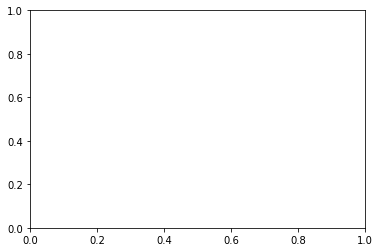

In [70]:
hidden_dir="out/hidden_state"
if not os.path.isdir(hidden_dir):
    os.makedirs(hidden_dir)

# debug recurrent module
for t in range(23):
    grid_hidden_state=hidden_state_list[t].eval(fd)
    cur_dir=os.path.join(hidden_dir,"time_step_{}".format(t))
    if not os.path.isdir(cur_dir):
        os.makedirs(cur_dir)
    for i in range(4):
        for j in range(4):
            for k in range(4):
                cell_hidden_state=grid_hidden_state[i,j,k] 
                plt.figure()
                plt.plot(cell_hidden_state)
                plt.savefig(os.path.join(cur_dir,'cell_{}{}{}.png'.format(i,j,k)))
                plt.close()

In [ ]:
decoder_dir="out/decoder"
# debug decoder net
voxel=tf.argmax(y_hat,axis=4)
voxel=tf.cast(voxel,dtype=tf.float32)

out=voxel.eval(fd)
outvoxel=binvox_rw.Voxels(out,out.shape,[0,0,0],1,'xzy')
with open("out/voxels/{}.binvox".format(),'w') as f:
    outvoxel.write(f)

/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


KeyboardInterrupt: 

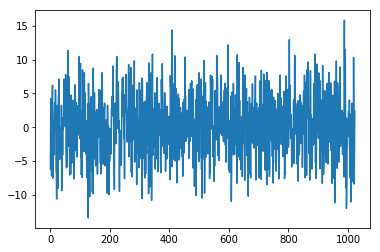

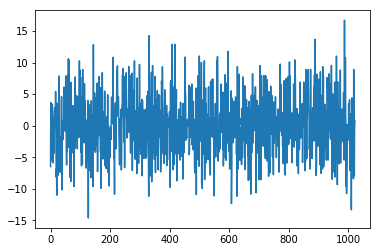

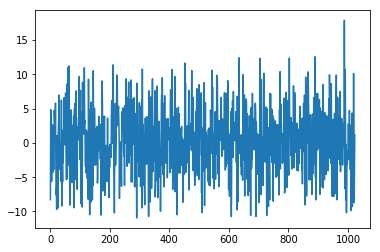

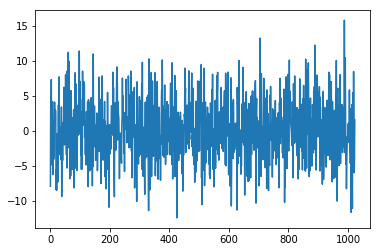

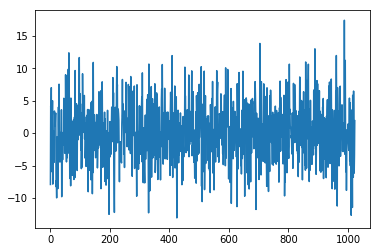

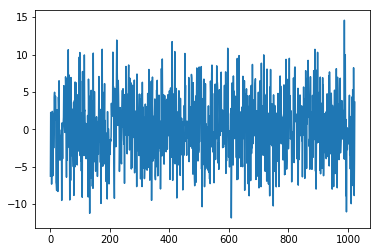

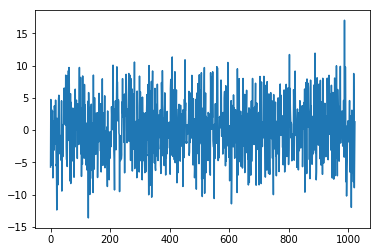

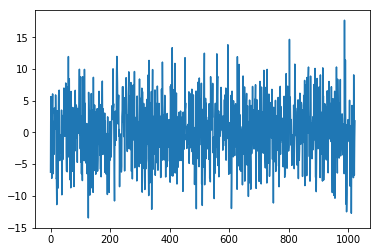

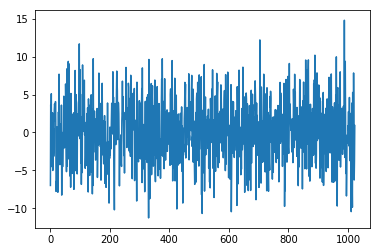

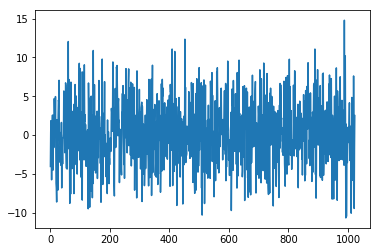

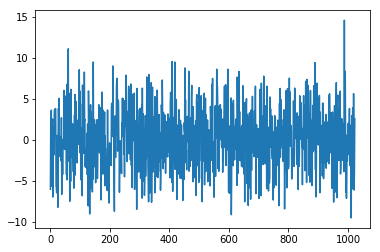

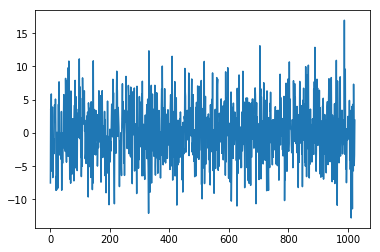

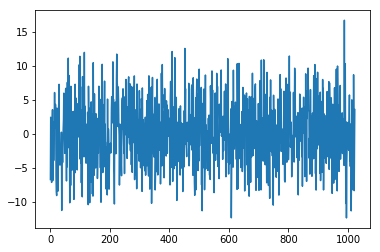

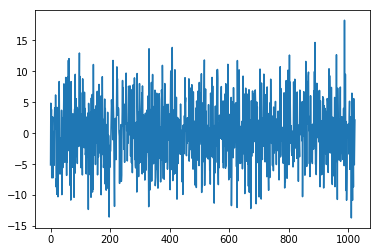

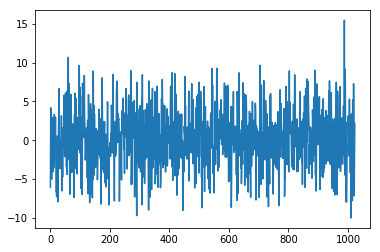

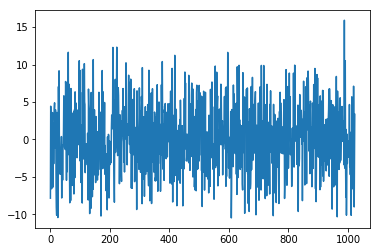

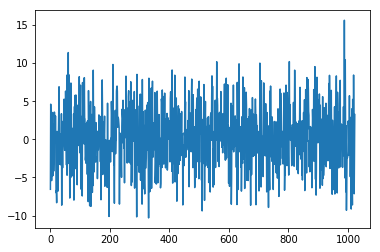

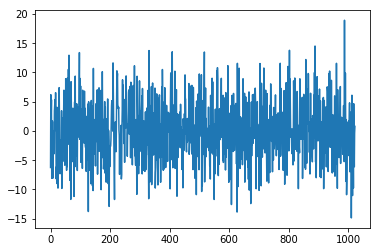

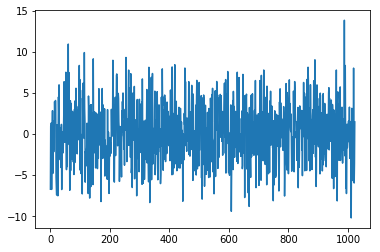

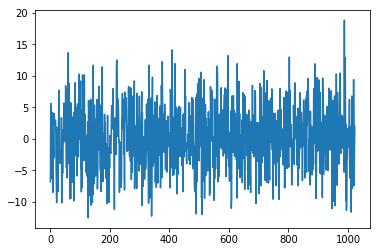

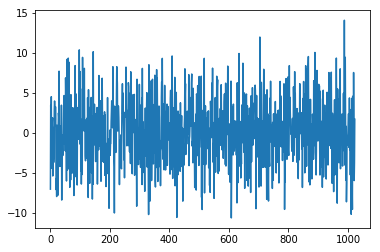

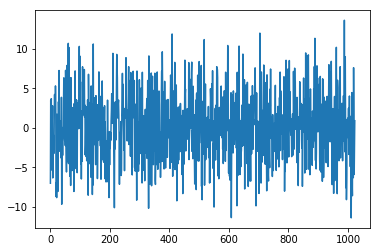

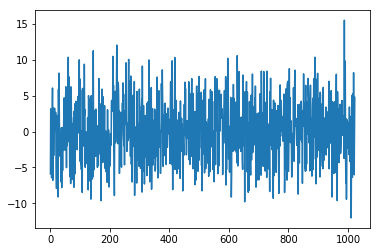

In [65]:
# enocder debug
encoder_dir="out/encoder"

batch_size,time_steps,n_layers=shapenet.batch_size,24,7
for b in range(batch_size):
    for t in range(time_steps):
        out_dir=os.path.join(out_root_dir,str(b),str(t))
        if not os.path.isdir(out_dir):
            os.makedirs(out_dir)
        
        for i in range(n_layers):
            var=encoder_outputs[i]
            var=var[b,t]
            utils.imsave_multichannel(var.eval(fd),out_dir+"/layer_{}.png".format(str(i)))
        
        var=encoder_outputs[n_layers]
        var=var.eval(fd)
        var=var[b,t]
        plt.figure()
        plt.plot(var)
        plt.savefig(out_dir+"/{}(feature_vector).png".format(str(n_layers)))